In [1]:
'''
#link to dataset below
https://www.kaggle.com/rmisra/news-headlines-dataset-for-sarcasm-detection

The dataset contains a JSON file with data of over 20K. It contains LINKS of news articles, their HEADLINES and a LABEL which indicates if the HEADLINE is sarcastic or not. 

We would try to classify if a news headline is sarcastic or not.
'''
import json
from bs4 import BeautifulSoup
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


#create dictionary to store extracted JSON
datastore = {'article_link': [], 'headline': [], 'is_sarcastic': []}
data = [json.loads(line) for line in open('sarcasm.json', 'r')]
for item in data:
    datastore['article_link'].append(item['article_link'])
    datastore['headline'].append(item['headline'])
    datastore['is_sarcastic'].append(item['is_sarcastic'])

# data = json.dumps(datastore, indent=2) 
stopWords = stopwords.words('english') #store variable to remove stopwords
table = str.maketrans('', '', string.punctuation) #varaible to store punctations

sentences = []
labels = []
urls = []

for item in datastore['headline']:
    sentence = item.replace(",", " , ").replace(".", " . ").replace("-", " - ").replace("/", " / ")
    soup = BeautifulSoup(sentence) #to remove all HTML and CSS tags
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ''
    for word in words:
        word = word.translate(table)
        if word not in stopWords:
            filtered_sentence = filtered_sentence + word + ' '
    sentences.append(filtered_sentence)

# we do not really need the URLs, just the LABELS would do
labels = datastore['is_sarcastic'].copy()
urls = datastore['article_link'].copy()

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, LSTM
from tensorflow.keras import Sequential, optimizers
import numpy as np


vocab_size, embedding_dim = 20000, 64
training_size = 23000

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# the 'NUM of WORDS' parameter must be less than or equal to the VOCAB_SIZE
#20K was originally used but VAL_ACC was poor
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index #get the word index

training_sentences = tokenizer.texts_to_sequences(training_sentences)
testing_sentences = tokenizer.texts_to_sequences(testing_sentences)

#padding is done to make each sequence of equal length
training_padded = pad_sequences(training_sentences, padding='post', maxlen=10, truncating='post')
testing_padded = pad_sequences(testing_sentences, maxlen=10, padding='post', truncating='post')
#comment out below code to print out word index
# print(word_index) 

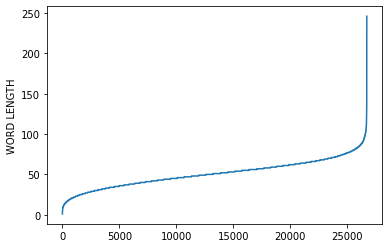

In [3]:
#plot the WORD LENGTH, so we can know the lenght of each sentences
x1 = []
y1 = []
current_item = 1
for item in sentences:
    x1.append(current_item)
    current_item += 1
    y1.append((len(item)))
y2 = sorted(y1)

#very few sentences have a corpus of 100+ words 
#this was the reason we set MAX_LEN in PAD_SEQ to 30
plt.plot(x1, y2)
plt.ylabel('WORD LENGTH')
plt.show()

In [4]:
from collections import OrderedDict

#get the WORD COUNT in descending order
wc = tokenizer.word_counts
newList = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
# print(newList)

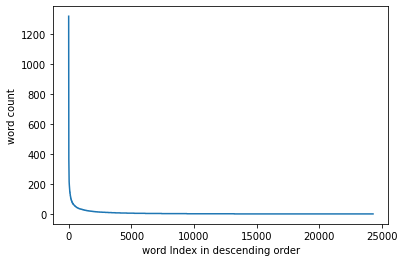

In [5]:
#exploring Vocab Size
xs, ys = [], []
curr_x = 1
for item in newList:
    xs.append(curr_x)
    curr_x += 1
    ys.append(newList[item])

#the below graph shows that very few words are used many times
plt.plot(xs, ys)
plt.xlabel('word Index in descending order')
plt.ylabel('word count')
plt.show()

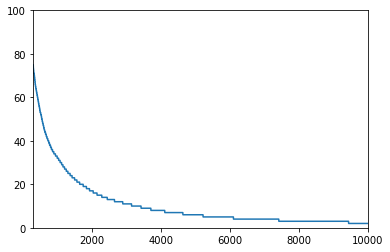

In [6]:
'''
Instead of training a huge corpus of words, let's focus on the most frequent words and train on them. That is, where the plot curves
'''
plt.plot(xs, ys)
plt.axis([300, 10000, 0, 100])
plt.show()

In [7]:
#convert to numpy format so we can impute into TF
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

#you can tune the DROPOUT, Regularizer, Batch Normalization
model = Sequential([
    Embedding(vocab_size, embedding_dim),
    Bidirectional(LSTM(embedding_dim, return_sequences=True, dropout=0.2)),
    Bidirectional(LSTM(embedding_dim, dropout=0.2)),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])

adam = optimizers.Adam(learning_rate=0.000008, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [8]:
history = model.fit(training_padded, training_labels, batch_size=32, epochs=40, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/40
719/719 - 69s - loss: 0.6903 - accuracy: 0.5567 - val_loss: 0.6859 - val_accuracy: 0.5700
Epoch 2/40
719/719 - 53s - loss: 0.6829 - accuracy: 0.5596 - val_loss: 0.6768 - val_accuracy: 0.5700
Epoch 3/40
719/719 - 54s - loss: 0.6758 - accuracy: 0.5635 - val_loss: 0.6697 - val_accuracy: 0.5886
Epoch 4/40
719/719 - 53s - loss: 0.6682 - accuracy: 0.5961 - val_loss: 0.6610 - val_accuracy: 0.6150
Epoch 5/40
719/719 - 54s - loss: 0.6561 - accuracy: 0.6237 - val_loss: 0.6451 - val_accuracy: 0.6379
Epoch 6/40
719/719 - 54s - loss: 0.6316 - accuracy: 0.6562 - val_loss: 0.6152 - val_accuracy: 0.6759
Epoch 7/40
719/719 - 53s - loss: 0.5931 - accuracy: 0.6939 - val_loss: 0.5769 - val_accuracy: 0.7134
Epoch 8/40
719/719 - 53s - loss: 0.5505 - accuracy: 0.7269 - val_loss: 0.5403 - val_accuracy: 0.7344
Epoch 9/40
719/719 - 54s - loss: 0.5163 - accuracy: 0.7443 - val_loss: 0.5238 - val_accuracy: 0.7460
Epoch 10/40
719/719 - 54s - loss: 0.4978 - accuracy: 0.7548 - val_loss: 0.5101 - val_accura

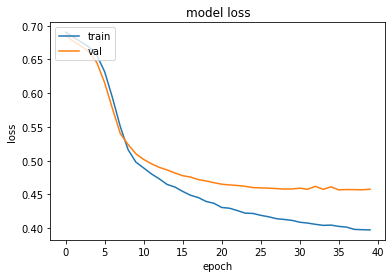

In [9]:
#model did not perform well enough
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

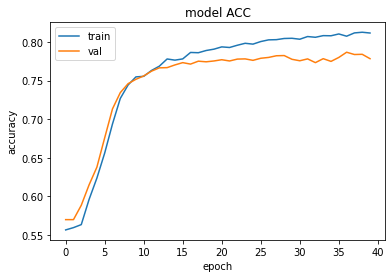

In [10]:
#the training and Validation ACC are far apart which shows that the model is over-fitting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model ACC')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Looking at the 2 graphs above, we can see that around the 40th epoch, things go brhhhhhhhh

In [11]:
#classify some sentences

sentences_x = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night", "TensorFlow book will be a best seller"]


#you can create a function to call for preprocessing
sentences_x = tokenizer.texts_to_sequences(sentences_x)
padded_x = pad_sequences(sentences_x, maxlen=10, padding='post', truncating='post')

#values from '0.5' to '1' indicate SARCASTIC headline, while values below indicate REAL headlines
#looking at the examples, we can say the model performed quite well.
predicted = model.predict(padded_x)
print(predicted)

[[0.7774762 ]
 [0.34712964]
 [0.33548635]]


In [12]:
#function to output classes
def sarc_check(x):
    for i in x:
        if i >= 0.5:
            print('SARCASTIC')
        else:
            print('Real headline')

#our model worked well as 
print(sarc_check(predicted))

SARCASTIC
Real headline
Real headline
None


#USing pretrained EMbeddings with RNNs

'''
Link below is to th 'GloVe' pre-trained embeddings
https://github.com/stanfordnlp/GloVe

The link contains pretrained word vectors for a variety of datasets. The one used for this practice is the 'Twitter Data' with 25-dimension version

Unfortunately, I didn't download it but the below code should work on it
'''

In [ ]:
'''
Link below is to th 'GloVe' pre-trained embeddings
https://github.com/stanfordnlp/GloVe

The link contains pretrained word vectors for a variety of datasets. The one used for this practice is the 'Twitter Data' with 25-dimension version

Unfortunately, I didn't download it but the below code should work on it.
Easiest way to use the dataset is to read it into a Dictionary as each entry in the dataset is a word, and the values are for the embeddings of the word.
'''

glove_embeddings = dict()
f = open('input file path link')
for line in f:
    values = line.split()
    word = values[0] #get the word
    coefs = np.asarray(values[1:], dtype='float32') #get the embeddings
    glove_embeddings[word] = coefs #store them here

f.close()

#you can look up coefficients of any word like this
glove_embeddings['word'] #outputs the coefs

#get the word index, and create the Embedding matrix 
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if index > vocab_size -1 :
        break
    else:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

'''
This simply creates a matrix with the dimensions of your desired vocab size and the embedding dimension. Then, for every item in the tokenizer’s word index, you look up the coefficients from GloVe in glove_embeddings, and add those values to the matrix.

You then amend the embedding layer to use the pretrained embeddings by setting the weights parameter, and specify that you don’t want the layer to be trained by setting trainable=False:
'''
#set the weights to the Embedding Matrix we created above

model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim)),
    Dense(24, activation='relu'),
    Dense(1, activation='sigmoid')
])
adam = optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
hist = model.fit(training_padded, training_labels, epochs=30, batch_size=32, validation_data=(testing_padded, testing_labels))

#the code below is used to checkout how many of the tokens in our original dataset is present in the Glove Dataset so that we can adjust the parameters of the vocab_size & embedding_dim
xs = []
ys = []
cumulative_x = []
cumulative_y = []
total_y = 0
for word, index in tokenizer.word_index.items():
    xs.append(index)
    cumulative_x.append(index)
    if glove_embeddings.get(word) is not None:
        total_y += 1
        ys.append(1)
    else:
        ys.append(0)
    cumulative_y.append(total_y / index)

#plot XS and YS
fig, ax = plt.subplots(figsize=(12, 2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)


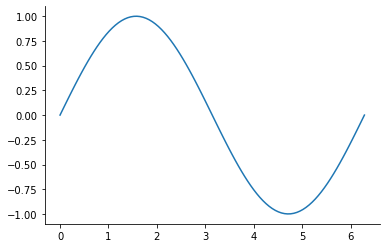

In [23]:
#playing around with SPINES in matplotlib, this ain't part of the tutorial
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)

ax = plt.subplot(111)
ax.plot(x, y)

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [ ]:
# <OOV>': 1, 'new': 2,
#get the reversed word index and the weights for each word
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
weights = model.layers[0].get_weights()[0]

#embeddings for the WORD at a certain index
print(reverse_word_index[5])
print(weights[5])

In [ ]:
import io

#create variables to store the EMBEDDing vectors and words, so we can visualize them
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# vocab_size = 2000, you should declare this ahead so you can call it whenever
for word_num in range(1, 2000):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_v.close()
out_m.close()
#you can visualize the embeddings above using Tensor Board

Example of using pre-trained Embeddings

In [ ]:
import tensorflow_hub as hub

#download the pre-trained embedding which comes with preprocessing
hub_layer = hub.keras_layer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20], input_shape=[], dtype=tf.string, trainable=False)

#pass directly to the model
model = tf.keras.Sequential([hub_layer,
                            Dense(16, activation='relu',
                            Dense(1, activation='sigmoid'))]
)

adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])